### Single Head Attention

In [43]:
import torch 
import torch.nn as nn

In [44]:
import torch.optim as optim

In [45]:
torch.manual_seed(0) # for reproducibility

In [46]:
# Defining parameters for the transformer model

n_embed = 120
n_layers = 8
n_heads = 8
head_size = n_embed // n_heads
batch_size = 32  # Batch size for training
block_size = 256  # Context size for the model
dropout = 0.2  # Dropout rate for regularization
vocab_size = 16000

learning_rate = 3e-4 
epochs = 10

In [47]:
## Train Data ( Copied from 2. Data Preparation )
from torch.utils.data import Dataset, DataLoader
import numpy as np
token_id_bin_path = "../../data/processed/Initial/initial_token_ids.bin"
token_ids = np.fromfile(token_id_bin_path, dtype=np.uint16)
class TokenDataset(Dataset):
    def __init__(self, token_ids, block_size ):
        self.block_size = block_size   
        self.data = np.array(token_ids, dtype=np.uint16)  # our data is going to be an np array ( for easy slicing )

    def __len__(self):
        return (self.data).shape[0] - self.block_size   

    def __getitem__(self, idx):
        X = torch.tensor(self.data[idx:idx+self.block_size], dtype=torch.long)
        y = torch.tensor(self.data[idx+1 : idx+self.block_size + 1], dtype = torch.long)

        return X, y

## Lets just quickly split the dataset  -- first 80% be train data
split_idx = int(0.8 * len(token_ids))
train_token_ids = token_ids[:split_idx]
val_token_ids = token_ids[split_idx:]

len(train_token_ids), len(val_token_ids)
token_dataset = TokenDataset(train_token_ids, block_size)
trainloader = DataLoader(token_dataset, batch_size = batch_size, shuffle=True, drop_last = True)


We know that for each token it consist a embedding vector of dimension n_embed.

i.e.. Ei vector of size n_embed*1                ,where i runs to block_size

And for each head there is a query matrix and key matrix of size head_size*n_embed. 
Which is applied to same x for self-head attention

and Qi = Wq * Ei = head_size*1 for each block_size and batch_size

It can be represented as Linear(n_embed,head_size)

How much each query vector attends to key vector is represented from dot product of Ki.Qi at each cell of matrix of size TxT

this is represented by 
Attend = query @ key

and the x is represented with the down projection to the dimension of head_size which is concatenated later
Vi = Wv * Ei

output from single head = attend @ Vi

In [48]:
class SingleHeadAttention(nn.Module):

    def __init__(self, n_embed, head_size):
        super().__init__()

        self.n_embed = n_embed
        self.head_size = head_size
        self.key = nn.Linear(n_embed, head_size)
        self.query = nn.Linear(n_embed, head_size)
        self.value = nn.Linear(n_embed, head_size)
        self.register_buffer('trill', torch.tril(torch.ones(block_size, block_size)))  # Lower triangular matrix for masking
 

    def forward(self, x):
        B,T,C = x.shape  # B is Batch_size, T is Block_size, C is n_embed
        # x is a shape of Batch_size x Block_size x n_embed
        key= self.key(x)        # B,T,H = head_size
        query = self.query(x)   # B,T,H = head_size

        # B,T,H @ B,H,T
        attend = query @ key.transpose(-2, -1)  # B,T,T

        attend = attend / (self.head_size ** 0.5)  #  Scaled Dot-Product Attention Attention(Q,K,V)=softmax(QK^T/sqrt(d_k))V

        # trill = torch.tril(torch.ones(attend.shape[-1], attend.shape[-1]))  # Lower triangular matrix of block_size

        attend = attend.masked_fill(self.trill[:T, :T] == 0, float('-inf'))  # Masking future tokens

        attend = torch.softmax(attend, dim=-1) # Column-wise softmax IG

        value = self.value(x) # B,T,H  

        out = attend @ value  # B,T,H

        return out, attend ## attend is the attention matrix, for later visualization




In [49]:
class MultiHeadAttention(nn.Module):
    def __init__(self,n_embed, n_heads):
        super().__init__()
        self.n_embed = n_embed
        self.n_heads = n_heads
        self.head_size = n_embed // n_heads

        self.heads = nn.ModuleList([SingleHeadAttention(n_embed, self.head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        out_list = []
        att_list = []

        for head in self.heads:
            out, att = head(x)
            out_list.append(out)
            att_list.append(att)

        out = torch.cat(out_list, dim=-1)  # Concatenate outputs from all heads
        out = self.proj(out)
        out = self.dropout(out)

        att_stack = torch.stack(att_list, dim=1) # stack attention matrices from all heads ( B, n_heads, T, T)

        return out, att_stack

    

In [50]:
class feed_forward(nn.Module):

    # Multi-layer perceptron (MLP) for feed-forward network in transformer
    
    def __init__(self, n_embed):
        super().__init__()
        self.network = nn.Sequential(
        nn.Linear(n_embed, 4 * n_embed),  # Up-projection min of 4* n_embed from the paper Attention Is All You Need
        nn.ReLU(),
        nn.Linear(4 * n_embed, n_embed),  # Down-projection back to n_embed
        nn.Dropout(dropout)
        )
    
        
    def forward(self, x):

        return self.network(x)
    

In [51]:
#Single Bloack of the Transformer
class Block(nn.Module):

    def __init__(self, n_embed, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(n_embed, n_heads)
        self.feed_forward = feed_forward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):

        # Creating a residual connection around the attention layer
        norm_x = self.ln1(x)
        att_out, att_weights = self.attention(norm_x)

        x = x + att_out
        x = x + self.feed_forward(self.ln2(x))
        return x, att_weights

In [52]:
class Transformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.block_size = block_size

        self.token_embedding = nn.Embedding(vocab_size, n_embed)  # Token embeddings
        self.position_embedding = nn.Embedding(block_size, n_embed)
 
        self.blocks = nn.ModuleList([Block(n_embed, n_heads) for _ in range(n_layers)])

        self.layer_norm = nn.LayerNorm(n_embed)  # Final layer normalization

        self.linear = nn.Linear(n_embed, vocab_size)  # Output layer for vocabulary size

    def forward(self, x,target=None):
        x = x.long() ## Ensuring the x is of type long for embedding lookup    
        B, T = x.size()
        positions = torch.arange(0, T, device=x.device)
        # Get embeddings
        token_emb = self.token_embedding(x)  # (B, T, n_embed)
        pos_emb = self.position_embedding(positions)  # (T, n_embed)
        x = token_emb + pos_emb

        att_weights_all = []

        for block in self.blocks:
            x, att_weights = block(x)
            att_weights_all.append(att_weights)  # ( B, n_heads, T, T)

        x = self.layer_norm(x)  # Final layer normalization
        logits =self.linear(x)  # Output layer to get logits for vocabulary size. B,T,V
        if target is not None:
            # Reshape for loss calculation
            logits_flat = logits.view(-1, logits.size(-1))  # Reshape logits to (B*T, V)
            target_flat = target.view(-1)  # Reshape target to (B*T)
            loss = nn.CrossEntropyLoss()(logits_flat, target_flat)
            return logits, loss, att_weights_all  # Return logits
        else: 
            return logits, None, att_weights_all  # Return logits, not softmax probabilities
    
    
    def generate(self, idx, max_new_tokens):
        # idx = Batch_size x Block_size ... B,T
        self.eval()  # Set to evaluation mode
        with torch.no_grad():  # No need to compute gradients during generation
            for _ in range(max_new_tokens):
                # Crop idx to the last block_size tokens if it gets too long
                # This is the correct line to ensure 'idx_to_process' always has a length up to 'block_size'
                idx_to_process = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
                
                # *** ABSOLUTELY ENSURE THE LINE 'idx = idx[:,-block_size]' IS GONE FROM HERE ***
                # *** IT IS THE REASON FOR YOUR ERROR ***

                # Get predictions
                logits, _ , _ = self(idx_to_process)  # Pass the correctly shaped 'idx_to_process' to the forward pass
                
                # Focus only on the last time step
                logits = logits[:, -1, :]  # becomes (B, vocab_size)
                
                # Apply softmax to get probabilities
                probs = torch.softmax(logits, dim=-1)  # (B, vocab_size)
                
                # Sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
                
                # Append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
                
        return idx
        

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer()
model.to(device)


Transformer(
  (token_embedding): Embedding(16000, 120)
  (position_embedding): Embedding(256, 120)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x SingleHeadAttention(
            (key): Linear(in_features=120, out_features=15, bias=True)
            (query): Linear(in_features=120, out_features=15, bias=True)
            (value): Linear(in_features=120, out_features=15, bias=True)
          )
        )
        (proj): Linear(in_features=120, out_features=120, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feed_forward): feed_forward(
        (network): Sequential(
          (0): Linear(in_features=120, out_features=480, bias=True)
          (1): ReLU()
          (2): Linear(in_features=480, out_features=120, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((

In [58]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
Transformer                                             --
├─Embedding: 1-1                                        1,920,000
├─Embedding: 1-2                                        30,720
├─ModuleList: 1-3                                       --
│    └─Block: 2-1                                       --
│    │    └─MultiHeadAttention: 3-1                     58,080
│    │    └─feed_forward: 3-2                           115,800
│    │    └─LayerNorm: 3-3                              240
│    │    └─LayerNorm: 3-4                              240
│    └─Block: 2-2                                       --
│    │    └─MultiHeadAttention: 3-5                     58,080
│    │    └─feed_forward: 3-6                           115,800
│    │    └─LayerNorm: 3-7                              240
│    │    └─LayerNorm: 3-8                              240
│    └─Block: 2-3                                       --
│    │    └─MultiH

In [59]:
len(trainloader)

1464

In [60]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model.train()
train_losses = []
train_accuracies = []

for epoch in range(1):
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, (X, y) in enumerate(trainloader):
        total_batch_loss = 0
        X, y = X.to(device, dtype=torch.long), y.to(device, dtype=torch.long)
        logits, loss, _ = model(X, y) # Forward pass 
        epoch_loss += loss.item()

        # Accuracy computation
        preds = torch.argmax(logits, dim=-1)
        correct += (preds == y).sum().item()
        total += y.numel()


        optimizer.zero_grad(set_to_none=True)

        loss.backward() 
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")
    average_loss_epoch = epoch_loss / len(trainloader)
    accuracy = correct / total

    train_accuracies.append(accuracy)
    train_losses.append(average_loss_epoch)

    print(f"Epoch {epoch+1} completed — Avg Loss: {average_loss_epoch:.4f}, Accuracy: {accuracy*100:.2f}%")




Epoch [1/10], Batch [1/1464], Loss: 9.8641
Epoch [1/10], Batch [101/1464], Loss: 7.1596
Epoch [1/10], Batch [201/1464], Loss: 6.7863
Epoch [1/10], Batch [301/1464], Loss: 6.3211
Epoch [1/10], Batch [401/1464], Loss: 5.7957
Epoch [1/10], Batch [501/1464], Loss: 5.5414
Epoch [1/10], Batch [601/1464], Loss: 5.1327
Epoch [1/10], Batch [701/1464], Loss: 4.8968
Epoch [1/10], Batch [801/1464], Loss: 4.4582
Epoch [1/10], Batch [901/1464], Loss: 4.1753
Epoch [1/10], Batch [1001/1464], Loss: 3.9607
Epoch [1/10], Batch [1101/1464], Loss: 3.7086
Epoch [1/10], Batch [1201/1464], Loss: 3.4930
Epoch [1/10], Batch [1301/1464], Loss: 3.2853
Epoch [1/10], Batch [1401/1464], Loss: 3.1518
Epoch 1 completed — Avg Loss: 4.9787, Accuracy: 19.53%


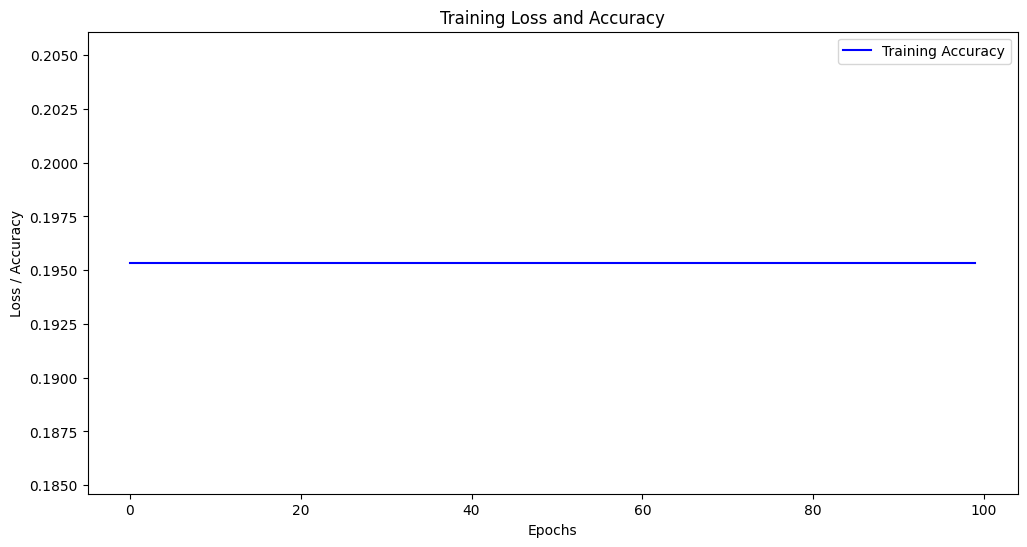

[0.19534993823108776] [4.978694922774216]


In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
# plt.plot(train_losses, label='Training Loss', color='red')
plt.plot(train_accuracies*100, label='Training Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.title('Training Loss and Accuracy')
plt.show()

print(train_accuracies, train_losses)

In [59]:
model_path = "../../models/initial_model_10E.pth"
torch.save(model.state_dict(), model_path)

##### Loading the model and teting the generation code: 

In [26]:
model.eval()
state_dict = torch.load(model_path)

# Create a new dict with renamed keys
new_state_dict = {}
for k, v in state_dict.items():
    # Replace "block." with "blocks." in all keys
    new_key = k.replace("block.", "blocks.")
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict)


<All keys matched successfully>

In [18]:
# Utility function to visualize attention weights
import matplotlib.pyplot as plt

def plot_attention(att_weights_all, layer=0, head=0, sample_idx=0):
    """
    Visualizes attention from a specific layer/head/sample.
    """
    att = att_weights_all[layer][sample_idx, head].detach().cpu().numpy()  # (T, T)

    plt.figure(figsize=(6, 5))
    plt.imshow(att, cmap='viridis')
    plt.title(f"Attention - Layer {layer}, Head {head}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.colorbar()
    plt.show()


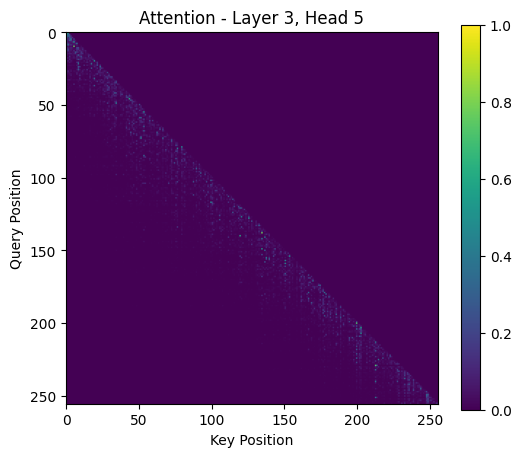

In [41]:
## xAI test
model.eval()
# sample_input = torch.tensor(val_token_ids[100:100+block_size]).unsqueeze(0).to(device)
seed_tensor = torch.tensor(val_token_ids[100:100+block_size]).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

logits, _, att_weights_all = model(seed_tensor)
plot_attention(att_weights_all, layer=3, head=5)


In [28]:
def attention_rollout(attentions, discard_ratio=0.0):
    print(f"Number of layers: {len(attentions)}")
    batch_size, heads, tokens, _ = attentions[0].shape
    print(f"Batch size: {batch_size}, Heads: {heads}, Tokens: {tokens}")

    result = torch.eye(tokens).unsqueeze(0).repeat(batch_size, 1, 1).to(attentions[0].device)
    print(f"Initial result shape: {result.shape}")

    for i, attn in enumerate(attentions):
        print(f"Layer {i} attn shape: {attn.shape}")
        attn_mean = attn.mean(dim=1)  # mean over heads
        print(f"attn_mean shape: {attn_mean.shape}")

        attn_mean = attn_mean / attn_mean.sum(dim=-1, keepdim=True)
        result = torch.bmm(attn_mean, result)
        print(f"Result shape after layer {i}: {result.shape}")

    return result


Number of layers: 8
Batch size: 1, Heads: 8, Tokens: 256
Initial result shape: torch.Size([1, 256, 256])
Layer 0 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 0: torch.Size([1, 256, 256])
Layer 1 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 1: torch.Size([1, 256, 256])
Layer 2 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 2: torch.Size([1, 256, 256])
Layer 3 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 3: torch.Size([1, 256, 256])
Layer 4 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 4: torch.Size([1, 256, 256])
Layer 5 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 5: torch.Size([1, 256, 256])
Layer 6 attn shape:

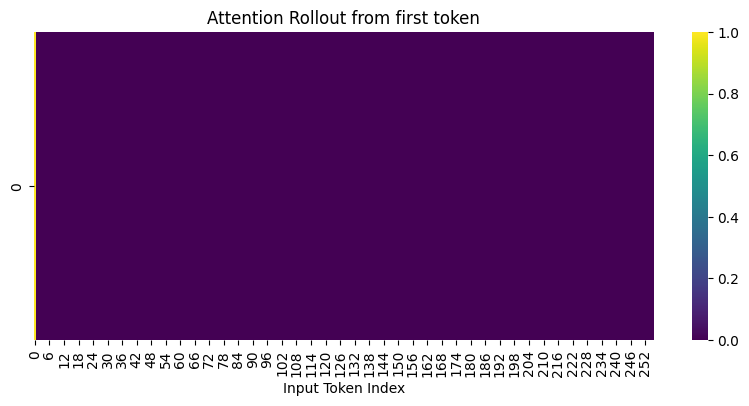

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

rollout = attention_rollout(att_weights_all)  # shape (B, T, T)
rollout_for_first_token = rollout[0, 0, :]  # first example, attention from token 0 to all tokens

plt.figure(figsize=(10, 4))
sns.heatmap(rollout_for_first_token.cpu().detach().numpy().reshape(1, -1), cmap="viridis", cbar=True)
plt.xlabel("Input Token Index")
plt.title("Attention Rollout from first token")
plt.show()


Number of layers: 8
Batch size: 1, Heads: 8, Tokens: 256
Initial result shape: torch.Size([1, 256, 256])
Layer 0 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 0: torch.Size([1, 256, 256])
Layer 1 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 1: torch.Size([1, 256, 256])
Layer 2 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 2: torch.Size([1, 256, 256])
Layer 3 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 3: torch.Size([1, 256, 256])
Layer 4 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 4: torch.Size([1, 256, 256])
Layer 5 attn shape: torch.Size([1, 8, 256, 256])
attn_mean shape: torch.Size([1, 256, 256])
Result shape after layer 5: torch.Size([1, 256, 256])
Layer 6 attn shape:

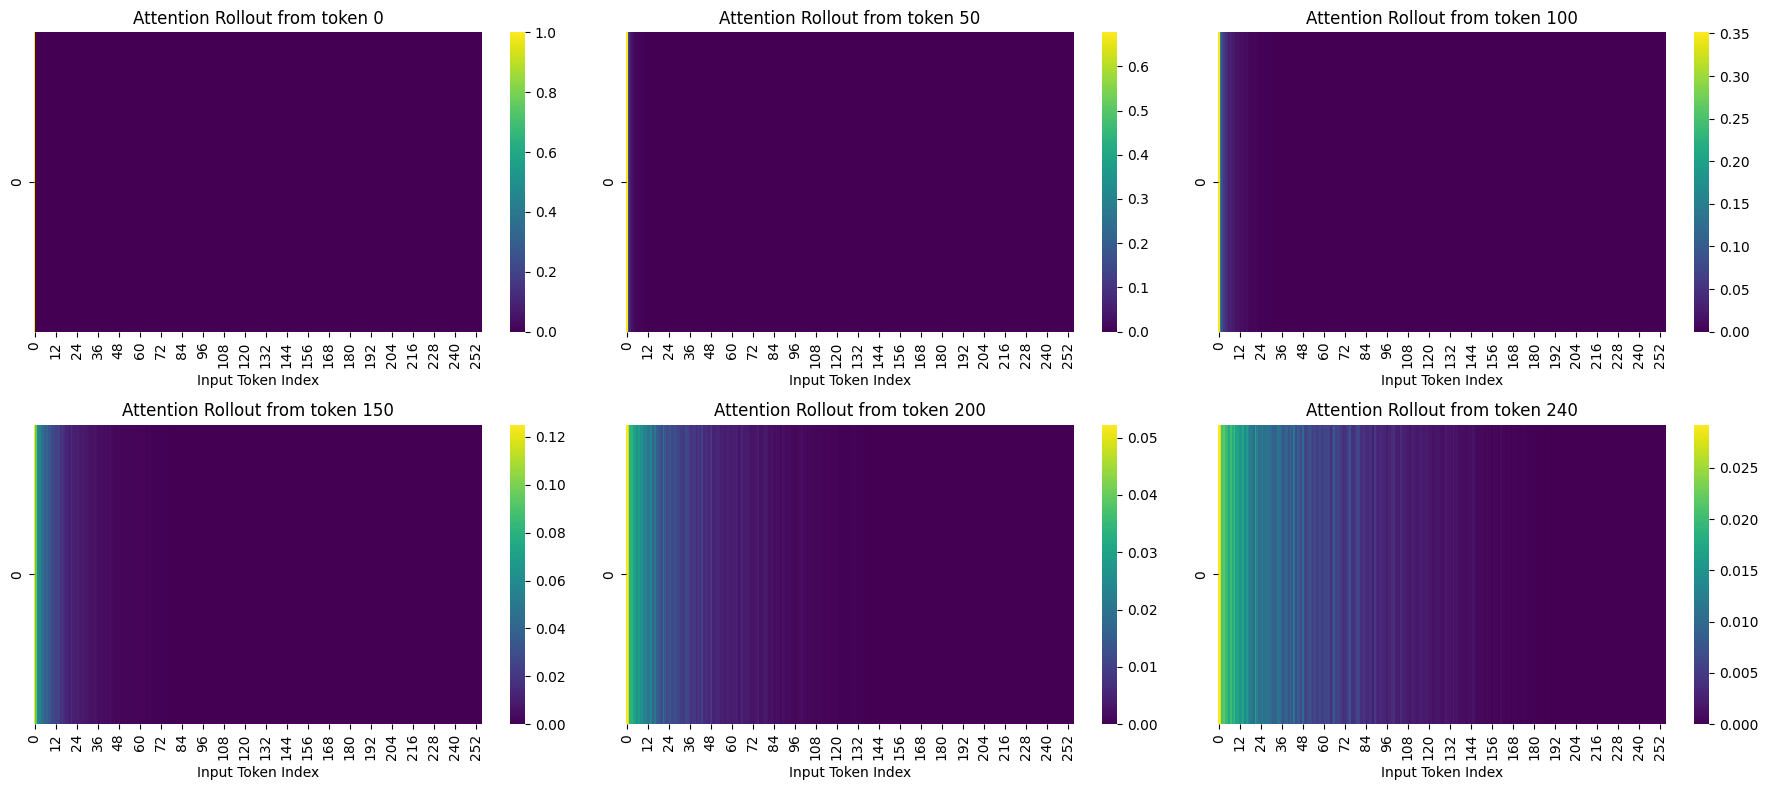

In [42]:
# Try different starting tokens
token_positions = [0, 50, 100, 150, 200, 240]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

rollout = attention_rollout(att_weights_all)

for i, token_pos in enumerate(token_positions):
    rollout_for_token = rollout[0, token_pos, :]  # attention from token_pos to all tokens
    
    sns.heatmap(rollout_for_token.cpu().detach().numpy().reshape(1, -1), 
                cmap="viridis", cbar=True, ax=axes[i])
    axes[i].set_xlabel("Input Token Index")
    axes[i].set_title(f"Attention Rollout from token {token_pos}")

plt.tight_layout()
plt.show()

ValueError: too many values to unpack (expected 2)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
 ## Generation using the 'generate function' 
output = model.generate(idx=torch.zeros(1, block_size, dtype=torch.long).to(device), max_new_tokens=40)

ValueError: too many values to unpack (expected 2)

In [49]:
output.shape

torch.Size([1, 296])

In [54]:
output = output.cpu()
msg = output.numpy()
msg[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [37]:
import sentencepiece as spm 
sp = spm.SentencePieceProcessor()
sp.Load("tokenizer.model")

True

In [36]:
sp.decode(msg[0].tolist())

NameError: name 'msg' is not defined

In [38]:
encoded = sp.encode("""In the following, we compare and contrast two implementations of QCD+QED with C
boundary conditions, consistent at next-to-leading order in the electromagnetic coupling,
to test their efficiency and utility. On one hand, we expand around an action defined
by QCD in the isospin-symmetric limit, `a la Rome-123 (RM123) [38, 39], while on the
other hand we simulate directly the joint QCD+QED distribution non-perturbatively. In
both cases, all effects from the sea quarks are completely included, making the comparison
unambiguous at leading order in the""")
encoded = np.array(encoded)
encoded.shape

(137,)

In [40]:

# Ensure 'device' is defined (e.g., 'cuda' or 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Convert to PyTorch tensor, add batch dimension, and move to device
seed_tensor = torch.from_numpy(encoded).long().unsqueeze(0).to(device)

print(f"Final seed tensor shape: {seed_tensor.shape}")
print(f"Final seed tensor device: {seed_tensor.device}")
print(f"Final seed tensor dtype: {seed_tensor.dtype}")
print(f"Final seed tensor: {seed_tensor}")


Final seed tensor shape: torch.Size([1, 137])
Final seed tensor device: cuda:0
Final seed tensor dtype: torch.int64
Final seed tensor: tensor([[ 154,   12, 2721, 7870,  194, 2939,   34, 2482,  947, 1517,  132,   27,
         1612, 7817, 7943, 7936, 5744,  106,  126, 3763, 1194, 7870, 2508,  401,
         2237, 7880,  855, 7880, 5182, 1963,   23,   12, 5702, 7234, 7870,   40,
         2086,  299, 2509,   34, 1642,   78, 7873, 3451,  524, 2622, 7870,  194,
         3686, 1977,   26, 6895, 3722,  148, 1612, 7817,   23,   12,   73, 4694,
            6, 7880, 7858, 2035, 7864, 3151, 1268, 7870, 7851,    1, 7855, 5959,
         6398, 1893, 1776,   58, 7895, 7892, 4591, 1605, 1341, 2530,  198, 7897,
          578,  872,   95,   12,  412, 2622,  194,  376,  123, 1589,   12, 2648,
         1612, 7817, 7943, 7936, 5744,  656,  492, 7880,  162, 6412, 1106, 7873,
          154,  599, 1841, 7870,  726,  993,  209,   12,  405, 7855,  390,  345,
         7858,  134, 7493, 7259, 7870, 1503,   12, 2155

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
 ## Generation using the 'generate function' 
output = model.generate(idx=seed_tensor, max_new_tokens=40)
output = output.cpu()
msg = output.numpy()
sp.decode(msg[0].tolist())

'In the following, we compare and contrast two implementations of QCD+QED with C boundary conditions, consistent at next-to-leading order in the electromagnetic coupling, to test their efficiency and utility. On one hand, we expand around an action defined by QCD in the isospin-symmetric limit,  ⁇ a la Rome-123 (RM123) [38, 39], while on the other hand we simulate directly the joint QCD+QED distribution non-perturbatively. In both cases, all effects from the sea quarks are completely included, making the comparison unambiguous at leading order in the ACM, and the details of (Ble Telescope (Rodríory, 2019), is a categorical classification of the intermediate versions of the term). In Figure 1, the formatting of the trajectory'